In [45]:
# 이미지 사이즈 조정
import cv2
import os
import json

def resize_images(directory, target_size):
    filelist = os.listdir(directory)
    for filename in filelist:
        if filename.endswith(".jpg") or filename.endswith(".png"):  # 원하는 확장자로 변경
            file_path = os.path.join(directory, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # 용량과 노이즈를 줄이기위해 리사이징한 이미지는 회색조로 사용
            resized_img = cv2.resize(img, dsize = target_size, interpolation=cv2.INTER_AREA)  # 크기 조정
            filename = filename.split('.jpg')[0] + '_aug' + '.jpg' # 사이즈를 조정한 이미지는 파일명에 뒤에 aug라는 이름 추가
            cv2.imwrite('...' + filename, resized_img)
                    
            

# 이미지가 저장된 디렉토리 경로와 목표 크기 지정
directory_path = '...' # 기존 사이즈 : 1920 x 1080
target_size = (640, 640)  # 리사이징할 이미지의 (가로, 세로) 크기

# 이미지 크기 조정 함수 호출
resize_images(directory_path, target_size)

In [47]:
# 사이즈를 조정한 학습 데이터들의 라벨 파일 목록
import pandas as pd
df = pd.read_csv('sample_train_file.csv')[['label_name']]
df.head()

,label_name
0,S002501_032_0126_C_D_F_0.json
1,S000574_063_0480_C_D_F_0.json
2,C000890_000_0198_C_D_F_0.json
3,S000506_004_0048_C_D_F_0.json
4,S000801_033_0036_C_D_F_0.json


In [54]:
# 이미지가 리사이징 되었기 때문에 변환된 이미지 크기에 맞게 라벨의 좌표도 조정해주어야 한다.
def resize_labels(directory, target_size):
    for filename in os.listdir(directory):
        file_path = directory + '/' + filename
        if filename.endswith(".json"):
            with open(file_path, 'r', encoding = 'utf-8', errors='ignore') as f:
                data = json.load(f)
            
            image_width = data['description']['imageWidth']
            image_height = data['description']['imageHeight']
            
            for obj in data['annotations']['PM']: 
                bbox = obj['points']
                x, y, bbox_width, bbox_height = bbox
                # 이미지 크기에 맞게 라벨링 데이터의 좌표 사이즈 조절.
                x_resized = x * target_size[0] / image_width
                y_resized = y * target_size[1] / image_height
                w_resized = bbox_width * target_size[0] / image_width
                h_resized = bbox_height * target_size[1] / image_height
                
                obj['points'] = [x_resized, y_resized, w_resized, h_resized]
            
            data['description']['imageWidth'] = target_size[0]
            data['description']['imageHeight'] = target_size[1]
            
            #filename = filename.split('.json')[0] + '_aug' + '.json'

            with open('...' + filename, 'w', encoding='utf-8') as file:
                json.dump(data, file, indent = '\t')

# 이미지가 저장된 디렉토리 경로와 목표 크기 지정
label_path = '...'
target_size = (640, 640)  # (가로, 세로) 크기
# 이미지 resizing에 따른 라벨의 좌표 조정

resize_labels(label_path, target_size) 

In [50]:
with open('data/sample_train/aug_label/C000099_103_0336_C_D_R_0.json', 'r') as f:
    lab = json.load(f)

In [51]:
bbox = lab['annotations']['PM'][0]['points']
x, y, w, h = bbox
x, y, w, h = int(x), int(y), int(w), int(h)
print(x, y, w, h)

989 587 41 95


(1080, 1920, 3)


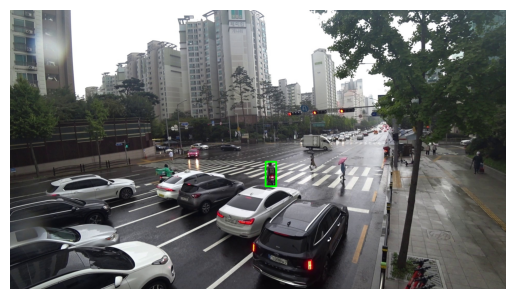

In [53]:
# 기존 이미지와 바운딩 박스
import matplotlib.pyplot as plt
img1 = cv2.imread('data/sample_aug/images/C000099_103_0336_C_D_R_0.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print(img1.shape)
plt.axis('off')
plt.imshow(img1)

cv2.rectangle(img1, (x,y), (x+w, y+h), (0, 255, 0), 5)
plt.imshow(img1)

In [54]:
with open('data/sample_train/aug_label/C000099_103_0336_C_D_R_0_aug.json', 'r') as f:
    lab2 = json.load(f)

In [55]:
bbox = lab2['annotations']['PM'][0]['points']
x, y, w, h = bbox
x, y, w, h = int(x), int(y), int(w), int(h)
print(x, y, w, h)

214 226 8 36


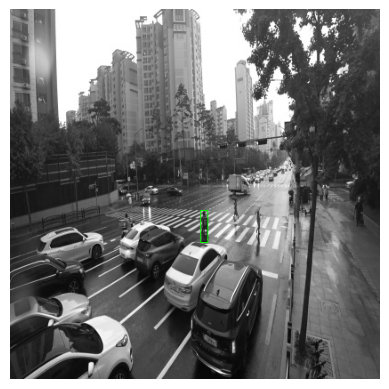

In [56]:
# 리사이징과 회색조 이미지가 적용된 증강 이미지와 바운딩 박스
import matplotlib.pyplot as plt
img1 = cv2.imread('data/sample_aug_640/images/C000099_103_0336_C_D_R_0_aug.jpg')
plt.axis('off')
plt.imshow(img1)

cv2.rectangle(img1, (x,y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(img1)

In [84]:
# yolo 라벨링 형식으로 txt 파일 생성
import json

normal = ['13', '20', '21', '28', '29'] # 정상
ped = ['14', '22', '30'] # 보행자 통행도로 위반
passenger = ['36'] # 동승자 탑승 위반
safe = ['15', '23', '31'] # 안전모 착용 위반
jay = ['16', '24', '32'] # 무단 횡단
signal = ['17', '25', '33'] # 신호 위반
cross = ['19', '27', '35'] # 횡단보도 위반
stop = ['18', '26'] # 정지선 위반

def make_yolo_label(json_file):
    with open(json_file, 'r', encoding = 'utf-8', errors='ignore') as f:
        data = json.load(f)
            
    yolo_data = ''
    image_width = data['description']['imageWidth']
    image_height = data['description']['imageHeight']

    # 기존 23개로 라벨링 된 카테고리를 7개로 축소
    for obj in data['annotations']['PM']:
        if obj['PM_code'] in normal:
            label = 0
        elif obj['PM_code'] in ped:
            label = 1
        elif obj['PM_code'] in passenger:
            label = 2
        elif obj['PM_code'] in safe:
            label = 3
        elif obj['PM_code'] in jay:
            label = 4
        elif obj['PM_code'] in signal:
            label = 5
        elif obj['PM_code'] in cross:
            label = 6
        elif obj['PM_code'] in stop:
            label = 7
        
        bbox = obj['points']

        # Yolo 학습을 위해 0~1 사이로 좌표 데이터 정규화
        x, y, bbox_width, bbox_height = bbox
        x_center = (x + bbox_width / 2) / image_width
        y_center = (y + bbox_height / 2) / image_height
        bbox_width = bbox_width / image_width
        bbox_height = bbox_height / image_height

        yolo_data += f"{label} {x_center} {y_center} {bbox_width} {bbox_height}\n"
        yolo_file = '원하는 파일 경로' + json_file.split('/')[-1].split('.')[0] + '.txt'
            
    with open(yolo_file, 'w') as f:
        f.write(yolo_data)

In [87]:
#yolo 포멧으로 라벨링 파일 변환
from tqdm import tqdm

label_list = os.listdir('yolo 형식으로 변환하고자 하는 라벨 파일이 담긴 폴더. 학습 데이터')
label_list = ['학습 라벨링 데이터 폴더 경로' + name for name in label_list]
print(len(label_list))
for file_name in tqdm(label_list):
    make_yolo_label(file_name)

21316


100%|██████████| 21316/21316 [00:26<00:00, 816.46it/s] 


In [232]:
import pandas as pd
df = pd.read_csv('sample_val_file.csv')
df.head()

,code,name,type,pm별 위반 유형,PM,label_name,위반 유형
0,14,F000025_001_9989_C_D_F_1.jpg,위반,오토바이 탑승자_보행자도로 통행 위반,오토바이,F000025_001_9989_C_D_F_1.json,보행자도로 통행 위반
1,13,C001329_001_0128_C_D_F_0.jpg,정상,오토바이 탑승자,오토바이,C001329_001_0128_C_D_F_0.json,정상
2,20,S000638_018_0240_C_D_F_0.jpg,정상,자전거 탑승자,자전거,S000638_018_0240_C_D_F_0.json,정상
3,14,F000059_000_6008_C_D_F_1.jpg,위반,오토바이 탑승자_보행자도로 통행 위반,오토바이,F000059_000_6008_C_D_F_1.json,보행자도로 통행 위반
4,36,F000053_002_3782_C_D_F_1.jpg,위반,킥보드 탑승자_동승자 탑승 위반,킥보드,F000053_002_3782_C_D_F_1.json,동승자 탑승 위반


In [208]:
label_list = ['검증 라벨링 데이터 폴더 경로' + name for name in df['label_name']]
print(len(label_list))
for file_name in tqdm(label_list):
    make_yolo_label(file_name)

2665


100%|██████████| 2665/2665 [00:07<00:00, 369.74it/s]


##### 기존 위반 유형과 대분류 카테고리
##### ex) 대분류 카테고리 - 기존 위반 유형

보행자도로 통행 위반 - 14, 22, 30

동승자 탑승 위반 - 36

안전모 미착용 위반 - 15, 23, 31

무단횡단 위반 - 16, 24, 32

횡단보도 주행 위반 - 19, 27, 35

신호 위반 - 17, 25, 33

정지선 위반 - 18, 26

정상 - 13, 20, 21, 28, 29

---------------------------------------


##### 대분류 카테고리 라벨 맵핑

정상 - 0

보행자도로 통행 위반 - 1

동승자 탑승 위반 - 2

안전모 미착용 위반 - 3

무단횡단 위반 - 4

횡단보도 주행 위반 - 5

신호 위반 - 6

정지선 위반 - 7